## BPR 
### https://github.com/manohar029/Ecommerce-Implicit-Data-Recommender-System
### http://ethen8181.github.io/machine-learning/recsys/4_bpr.html

In [125]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas import DataFrame


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

from numpy.random import randint
import implicit
import scipy.sparse as sparse
import ml_metrics as metrics

from scipy.sparse import csr_matrix
from scipy.sparse import dok_matrix
import math
from tqdm import trange
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from itertools import islice
from sklearn.metrics import roc_auc_score
# from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("../Dataset/transactionWithRating.csv", sep="|")
# book = pd.read_csv("../Dataset/book.csv", sep="|")

# processed1 = pd.read_csv("../Dataset/processedDataWithThaliaAddedWithTranslatedTopics.csv")
# processed2 = pd.read_csv("../Dataset/processedDataForRemainedPart.csv", sep="|")
# processed1 = processed1.drop(["Unnamed: 0"], axis=1)

In [126]:
print(df.shape)
df.head(3)

(362381, 14)


,sessionID,ID_transaction,ID_processed,click,basket,order,title_book,author_book,click_bin,basket_bin,order_bin,rating_ex1,rating_ex2,rating_ex3
0,0,21310,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,1,0,0,0.25,1,0.5
1,1,73018,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,1,0,0,0.25,1,0.5
2,2,19194,19194|1878,1,0,0,Red Queen 1,Victoria Aveyard,1,0,0,0.25,1,0.5


<AxesSubplot:>

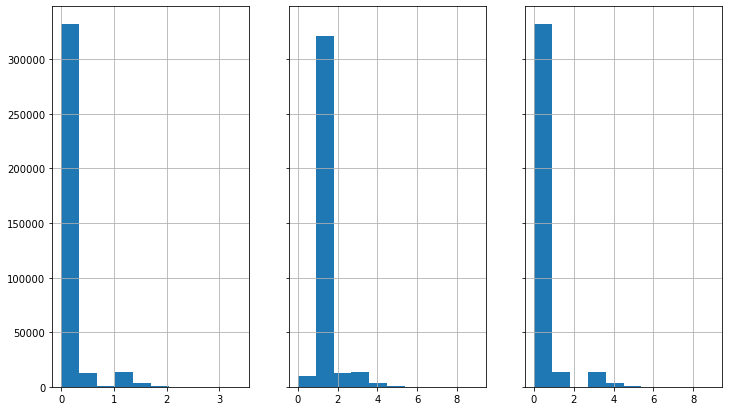

In [127]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

df['rating_ex1'].hist(ax=ax[0])
df['rating_ex2'].hist(ax=ax[1])
df['rating_ex3'].hist(ax=ax[2])

In [128]:
df = df[:1000]

In [129]:
df['rating_ex2'].describe()

count    1000.000000
mean        1.100000
std         0.567734
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: rating_ex2, dtype: float64

In [130]:
df['rating_ex3']

0      0.5
1      0.5
2      0.5
3      0.5
4      0.5
      ... 
995    0.5
996    0.5
997    0.5
998    0.5
999    0.5
Name: rating_ex3, Length: 1000, dtype: float64

In [131]:
def create_matrix(data, users_col, items_col, ratings_col, threshold = None):
    """
    creates the sparse user-item interaction matrix,
    if the data is not in the format where the interaction only
    contains the positive items (indicated by 1), then use the 
    threshold parameter to determine which items are considered positive
    
    Parameters
    ----------
    data : DataFrame
        implicit rating data

    users_col : str
        user column name

    items_col : str
        item column name
    
    ratings_col : str
        implicit rating column name

    threshold : int, default None
        threshold to determine whether the user-item pair is 
        a positive feedback

    Returns
    -------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        user/item ratings matrix

    data : DataFrame
        implict rating data that retains only the positive feedback
        (if specified to do so)
    """
    if threshold is not None:
        data = data[data[ratings_col] >= threshold]
        data[ratings_col] = 1
    
    for col in (items_col, users_col, ratings_col):
        data[col] = data[col].astype('category')

    ratings = csr_matrix((data[ratings_col],
                          (data[users_col].cat.codes, data[items_col].cat.codes)))
    ratings.eliminate_zeros()
    return ratings, data

In [132]:
items_col = 'sessionID'
users_col = 'ID_processed'
ratings_col = 'rating_ex2'
threshold = 0.3
X, df = create_matrix(df, users_col, items_col, ratings_col, threshold)
X

<786x726 sparse matrix of type '<class 'numpy.int64'>'
	with 961 stored elements in Compressed Sparse Row format>

In [133]:
def create_train_test(ratings, test_size = 0.2, seed = 1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them
    
    Parameters
    ----------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        The user-item interactions matrix
    
    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set
    
    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set
    
    Returns
    ------- 
    train : scipy sparse csr_matrix, shape [n_users, n_items]
        Training set
    
    test : scipy sparse csr_matrix, shape [n_users, n_items]
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = math.ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [134]:
X_train, X_test = create_train_test(X, test_size = 0.2, seed = 1234)
X_train

<786x726 sparse matrix of type '<class 'numpy.int64'>'
	with 171 stored elements in Compressed Sparse Row format>

In [357]:
class BPR:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data

    Parameters
    ----------
    learning_rate : float, default 0.01
        learning rate for gradient descent

    n_factors : int, default 20
        Number/dimension of user and item latent factors

    n_iters : int, default 15
        Number of iterations to train the algorithm
        
    batch_size : int, default 1000
        batch size for batch gradient descent, the original paper
        uses stochastic gradient descent (i.e., batch size of 1),
        but this can make the training unstable (very sensitive to
        learning rate)

    reg : int, default 0.01
        Regularization term for the user and item latent factors

    seed : int, default 1234
        Seed for the randomly initialized user, item latent factors

    verbose : bool, default True
        Whether to print progress bar while training

    Attributes
    ----------
    user_factors : 2d ndarray, shape [n_users, n_factors]
        User latent factors learnt

    item_factors : 2d ndarray, shape [n_items, n_factors]
        Item latent factors learnt

    References
    ----------
    S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme 
    Bayesian Personalized Ranking from Implicit Feedback
    - https://arxiv.org/abs/1205.2618
    """
    def __init__(self, learning_rate = 0.01, n_factors = 15, n_iters = 10, 
                 batch_size = 1000, reg = 0.01, seed = 1234, verbose = True):
        self.reg = reg
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # to avoid re-computation at predict
        self._prediction = None
        
    def fit(self, ratings):
        """
        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions
        """
        indptr = ratings.indptr
        indices = ratings.indices
        n_users, n_items = ratings.shape
        
        # ensure batch size makes sense, since the algorithm involves
        # for each step randomly sample a user, thus the batch size
        # should be smaller than the total number of users or else
        # we would be sampling the user with replacement
        batch_size = self.batch_size
        if n_users < batch_size:
            batch_size = n_users
            sys.stderr.write('WARNING: Batch size is greater than number of users,'
                             'switching to a batch size of {}\n'.format(n_users))

        batch_iters = n_users // batch_size
        
        # initialize random weights
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (n_items, self.n_factors))
        
        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc = self.__class__.__name__)
        
        for _ in loop:
            for _ in range(batch_iters):
                sampled = self._sample(n_users, n_items, indices, indptr)
                sampled_users, sampled_pos_items, sampled_neg_items = sampled
                self._update(sampled_users, sampled_pos_items, sampled_neg_items)

        return self
    
    def _sample(self, n_users, n_items, indices, indptr):
        """sample batches of random triplets u, i, j"""
        sampled_pos_items = np.zeros(self.batch_size, dtype = np.int)
        sampled_neg_items = np.zeros(self.batch_size, dtype = np.int)
        sampled_users = np.random.choice(
            n_users, size = self.batch_size, replace = False)

        for idx, user in enumerate(sampled_users):
            if len(indices[indptr[user]:indptr[user + 1]]) > 0:
                
                pos_items = indices[indptr[user]:indptr[user + 1]]
#                 print("33pos_items:", pos_items)
                pos_item = np.random.choice(pos_items)
                neg_item = np.random.choice(n_items)
                while neg_item in pos_items:
                    neg_item = np.random.choice(n_items)

                sampled_pos_items[idx] = pos_item
                sampled_neg_items[idx] = neg_item
#                 print(sampled_pos_items, sampled_neg_items)

        return sampled_users, sampled_pos_items, sampled_neg_items
                
    def _update(self, u, i, j):
        """
        update according to the bootstrapped user u, 
        positive item i and negative item j
        """
        user_u = self.user_factors[u]
        item_i = self.item_factors[i]
        item_j = self.item_factors[j]
        
        # decompose the estimator, compute the difference between
        # the score of the positive items and negative items; a
        # naive implementation might look like the following:
        # r_ui = np.diag(user_u.dot(item_i.T))
        # r_uj = np.diag(user_u.dot(item_j.T))
        # r_uij = r_ui - r_uj
        
        # however, we can do better, so
        # for batch dot product, instead of doing the dot product
        # then only extract the diagonal element (which is the value
        # of that current batch), we perform a hadamard product, 
        # i.e. matrix element-wise product then do a sum along the column will
        # be more efficient since it's less operations
        # http://people.revoledu.com/kardi/tutorial/LinearAlgebra/HadamardProduct.html
        # r_ui = np.sum(user_u * item_i, axis = 1)
        #
        # then we can achieve another speedup by doing the difference
        # on the positive and negative item up front instead of computing
        # r_ui and r_uj separately, these two idea will speed up the operations
        # from 1:14 down to 0.36
        r_uij = np.sum(user_u * (item_i - item_j), axis = 1)
        sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
        
        # repeat the 1 dimension sigmoid n_factors times so
        # the dimension will match when doing the update
        sigmoid_tiled = np.tile(sigmoid, (self.n_factors, 1)).T

        # update using gradient descent
        grad_u = sigmoid_tiled * (item_j - item_i) + self.reg * user_u
        grad_i = sigmoid_tiled * -user_u + self.reg * item_i
        grad_j = sigmoid_tiled * user_u + self.reg * item_j
        self.user_factors[u] -= self.learning_rate * grad_u
        self.item_factors[i] -= self.learning_rate * grad_i
        self.item_factors[j] -= self.learning_rate * grad_j
        return self

    def predict(self):
        """
        Obtain the predicted ratings for every users and items
        by doing a dot product of the learnt user and item vectors.
        The result will be cached to avoid re-computing it every time
        we call predict, thus there will only be an overhead the first
        time we call it. Note, ideally you probably don't need to compute
        this as it returns a dense matrix and may take up huge amounts of
        memory for large datasets
        """
        if self._prediction is None:
            self._prediction = self.user_factors.dot(self.item_factors.T)

        return self._prediction

    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        return user_pred

    def recommend(self, ratings, N = 1000):
        """
        Returns the top N ranked items for given user id,
        excluding the ones that the user already liked
        
        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions 
        
        N : int, default 5
            top-N similar items' N
        
        Returns
        -------
        recommendation : 2d ndarray, shape [number of users, N]
            each row is the top-N ranked item for each query user
        """
        n_users = ratings.shape[0]
        recommendation = np.zeros((n_users, N), dtype = np.uint32)
        for user in range(n_users):
            top_n = self._recommend_user(ratings, user, N)
            recommendation[user] = top_n

        return recommendation

    def _recommend_user(self, ratings, user, N):
        """the top-N ranked items for a given user"""
        scores = self._predict_user(user)
        print("**scores:", scores)
        

        # compute the top N items, removing the items that the user already liked
        # from the result and ensure that we don't get out of bounds error when 
        # we ask for more recommendations than that are available
        liked = set(ratings[user].indices)
        count = N + len(liked)
        if count < scores.shape[0]:

            # when trying to obtain the top-N indices from the score,
            # using argpartition to retrieve the top-N indices in 
            # unsorted order and then sort them will be faster than doing
            # straight up argort on the entire score
            # http://stackoverflow.com/questions/42184499/cannot-understand-numpy-argpartition-output
            ids = np.argpartition(scores, -count)[-count:]
            best_ids = np.argsort(scores[ids])[::-1]
            best = ids[best_ids]
        else:
            best = np.argsort(scores)[::-1]

        top_n = list(islice((rec for rec in best if rec not in liked), N))
        return top_n
    
    def get_similar_items(self, N = 5, item_ids = None):
        
        """
        return the top N similar items for itemid, where
        cosine distance is used as the distance metric
        
        Parameters
        ----------
        N : int, default 5
            top-N similar items' N
            
        item_ids : 1d iterator, e.g. list or numpy array, default None
            the item ids that we wish to find the similar items
            of, the default None will compute the similar items
            for all the items
        
        Returns
        -------
        similar_items : 2d ndarray, shape [number of query item_ids, N]
            each row is the top-N most similar item id for each
            query item id
        """
        # cosine distance is proportional to normalized euclidean distance,
        # thus we normalize the item vectors and use euclidean metric so
        # we can use the more efficient kd-tree for nearest neighbor search;
        # also the item will always to nearest to itself, so we add 1 to 
        # get an additional nearest item and remove itself at the end
        normed_factors = preprocessing.normalize(self.item_factors)
        knn = NearestNeighbors(n_neighbors = N + 1, metric = 'euclidean')
#         .fit(X)

        # returns a distance, index tuple,
        # we don't actually need the distance
        if item_ids is not None:
            normed_factors = normed_factors[item_ids]

        _, items = knn.kneighbors(normed_factors)
#         dist, items = knn.kneighbors(normed_factors, return_distance=True)
#         print(items)
       
        similar_items = items[:, 1:].astype(np.uint32)
      
        return similar_items

In [358]:
# parameters were randomly chosen
bpr_params = {'reg': 0.01,
              'learning_rate': 0.1,
              'n_iters': 10,
              'n_factors': 30,
              'batch_size': 150}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 10/10 [00:00<00:00, 172.40it/s]


In [359]:
bpr.get_similar_items(N = 2)

NotFittedError: This NearestNeighbors instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [349]:
# def auc_score(model, ratings):
#     """
#     computes area under the ROC curve (AUC).
#     The full name should probably be mean
#     auc score as it is computing the auc
#     for every user's prediction and actual
#     interaction and taking the average for
#     all users
    
#     Parameters
#     ----------
#     model : BPR instance
#         Trained BPR model
        
#     ratings : scipy sparse csr_matrix, shape [n_users, n_items]
#         sparse matrix of user-item interactions
    
#     Returns
#     -------
#     auc : float 0.0 ~ 1.0
#     """
#     auc = 0.0
#     n_users, n_items = ratings.shape
#     for user, row in enumerate(ratings):
#         y_pred = model._predict_user(user)
#         y_true = np.zeros(n_items)
#         y_true[row.indices] = 1
#         auc += roc_auc_score(y_true, y_pred)

#     auc /= n_users
#     return auc

In [350]:
# print(auc_score(bpr, X_train))
# print(auc_score(bpr, X_test))